<a href="https://colab.research.google.com/github/Awoutokoffisamson/machine-learning2/blob/main/tp-classification-revenue.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Summary

L'objectif est de construire un modèle de classification capable de **prédire si une personne gagne plus ou moins de 50 000 dollars par an**, en utilisant ses caractéristiques socio-démographiques.

Le jeu de données est **"Adult Income"** du [UCI Machine Learning Repository](https://archive.ics.uci.edu/).

- **[UCIMLREPO](https://github.com/uci-ml-repo/ucimlrepo) package**

Le package UCIMLRepo (pour **UCI Machine Learning Repository**) est une **bibliothèque Python** qui facilite l’accès aux jeux de données disponibles sur le célèbre dépôt [UCI Machine Learning Repository](https://archive.ics.uci.edu/). Il permet de **chercher, télécharger et utiliser facilement ces datasets directement dans un notebook Python**, sans avoir à passer par un téléchargement manuel.

## Packages

In [1]:
pip install dill imblearn pendulum ucimlrepo yellowbrick

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 119.7/119.7 kB 2.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 353.7/353.7 kB 8.9 MB/s eta 0:00:00


In [3]:
!pip install loguru

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.6/61.6 kB 4.6 MB/s eta 0:00:00


In [4]:
from pathlib import Path

import dill
import matplotlib.pyplot as plt
import missingno as msno
import numpy as np
import pandas as pd
import pendulum
import plotly.graph_objects as go
import plotly.express as px
import seaborn as sns
from imblearn.pipeline import Pipeline as imb_Pipeline
from loguru import logger
from sklearn import set_config
from sklearn.compose import make_column_transformer, ColumnTransformer
from sklearn.dummy import DummyClassifier
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (confusion_matrix,
                             classification_report,
                             ConfusionMatrixDisplay,
                             roc_auc_score,
                             accuracy_score,
                             precision_score,
                             recall_score,
                             f1_score,
                             RocCurveDisplay,
                             PrecisionRecallDisplay,
                            )
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler, OrdinalEncoder, OneHotEncoder
from ucimlrepo import fetch_ucirepo, list_available_datasets
from yellowbrick.classifier import DiscriminationThreshold

set_config(display='diagram')
pd.set_option("display.max_columns", None)

## Settings

In [5]:
EXECUTION_DATE = pendulum.now(tz="UTC")


ROOT_DIR = Path().cwd()
MODEL_DIR = Path(ROOT_DIR, "models")

MODEL_DIR.mkdir(parents=True, exist_ok=True)
logger.info(f"Model directory: {MODEL_DIR}")

2025-04-24 13:51:51.944 | INFO     | __main__:<cell line: 0>:8 - Model directory: /content/models


## Data collection

In [6]:
# check which datasets can be imported
list_available_datasets()

-------------------------------------
The following datasets are available:
-------------------------------------
Dataset Name                                                                            ID    
------------                                                                            --    
Abalone                                                                                 1     
Adult                                                                                   2     
Annealing                                                                               3     
Audiology (Standardized)                                                                8     
Auto MPG                                                                                9     
Automobile                                                                              10    
Balance Scale                                                                           12    
Balloons                       

In [7]:
# fetch dataset
adult = fetch_ucirepo(name="Adult", id=None)

# fetch data
data = adult.data.original

logger.info(f"{data.shape}")

2025-04-24 14:03:39.708 | INFO     | __main__:<cell line: 0>:7 - (48842, 15)


In [8]:
data.head()

age         workclass  fnlwgt  education  education-num  \
0   39         State-gov   77516  Bachelors             13   
1   50  Self-emp-not-inc   83311  Bachelors             13   
2   38           Private  215646    HS-grad              9   
3   53           Private  234721       11th              7   
4   28           Private  338409  Bachelors             13   

       marital-status         occupation   relationship   race     sex  \
0       Never-married       Adm-clerical  Not-in-family  White    Male   
1  Married-civ-spouse    Exec-managerial        Husband  White    Male   
2            Divorced  Handlers-cleaners  Not-in-family  White    Male   
3  Married-civ-spouse  Handlers-cleaners        Husband  Black    Male   
4  Married-civ-spouse     Prof-specialty           Wife  Black  Female   

   capital-gain  capital-loss  hours-per-week native-country income  
0          2174             0              40  United-States  <=50K  
1             0             0              13  United-States  <=50K  
2             0             0              40  United-States  <=50K  
3             0             0              40  United-States  <=50K  
4             0             0              40           Cuba  <=50K

In [9]:
# metadata
logger.info(f"Metadata \n {adult.metadata}")

# variable information
logger.info(f"Features: \n{adult.variables}")

2025-04-24 14:19:15.792 | INFO     | __main__:<cell line: 0>:2 - Metadata 
 {'uci_id': 2, 'name': 'Adult', 'repository_url': 'https://archive.ics.uci.edu/dataset/2/adult', 'data_url': 'https://archive.ics.uci.edu/static/public/2/data.csv', 'abstract': 'Predict whether annual income of an individual exceeds $50K/yr based on census data. Also known as "Census Income" dataset. ', 'area': 'Social Science', 'tasks': ['Classification'], 'characteristics': ['Multivariate'], 'num_instances': 48842, 'num_features': 14, 'feature_types': ['Categorical', 'Integer'], 'demographics': ['Age', 'Income', 'Education Level', 'Other', 'Race', 'Sex'], 'target_col': ['income'], 'index_col': None, 'has_missing_values': 'yes', 'missing_values_symbol': 'NaN', 'year_of_dataset_creation': 1996, 'last_updated': 'Tue Sep 24 2024', 'dataset_doi': '10.24432/C5XW20', 'creators': ['Barry Becker', 'Ronny Kohavi'], 'intro_paper': None, 'additional_info': {'summary': "Extraction was done by Barry Becker from the 1994 Cen

In [10]:
data.describe(include="all")

age workclass        fnlwgt education  education-num  \
count   48842.000000     47879  4.884200e+04     48842   48842.000000   
unique           NaN         9           NaN        16            NaN   
top              NaN   Private           NaN   HS-grad            NaN   
freq             NaN     33906           NaN     15784            NaN   
mean       38.643585       NaN  1.896641e+05       NaN      10.078089   
std        13.710510       NaN  1.056040e+05       NaN       2.570973   
min        17.000000       NaN  1.228500e+04       NaN       1.000000   
25%        28.000000       NaN  1.175505e+05       NaN       9.000000   
50%        37.000000       NaN  1.781445e+05       NaN      10.000000   
75%        48.000000       NaN  2.376420e+05       NaN      12.000000   
max        90.000000       NaN  1.490400e+06       NaN      16.000000   

            marital-status      occupation relationship   race    sex  \
count                48842           47876        48842  48842  48842   
unique                   7              15            6      5      2   
top     Married-civ-spouse  Prof-specialty      Husband  White   Male   
freq                 22379            6172        19716  41762  32650   
mean                   NaN             NaN          NaN    NaN    NaN   
std                    NaN             NaN          NaN    NaN    NaN   
min                    NaN             NaN          NaN    NaN    NaN   
25%                    NaN             NaN          NaN    NaN    NaN   
50%                    NaN             NaN          NaN    NaN    NaN   
75%                    NaN             NaN          NaN    NaN    NaN   
max                    NaN             NaN          NaN    NaN    NaN   

        capital-gain  capital-loss  hours-per-week native-country income  
count   48842.000000  48842.000000    48842.000000          48568  48842  
unique           NaN           NaN             NaN             42      4  
top              NaN           NaN             NaN  United-States  <=50K  
freq             NaN           NaN             NaN          43832  24720  
mean     1079.067626     87.502314       40.422382            NaN    NaN  
std      7452.019058    403.004552       12.391444            NaN    NaN  
min         0.000000      0.000000        1.000000            NaN    NaN  
25%         0.000000      0.000000       40.000000            NaN    NaN  
50%         0.000000      0.000000       40.000000            NaN    NaN  
75%         0.000000      0.000000       45.000000            NaN    NaN  
max     99999.000000   4356.000000       99.000000            NaN    NaN

In [11]:
data.columns = data.columns.str.replace("-", "_")
data.columns

Index(['age', 'workclass', 'fnlwgt', 'education', 'education_num',
       'marital_status', 'occupation', 'relationship', 'race', 'sex',
       'capital_gain', 'capital_loss', 'hours_per_week', 'native_country',
       'income'],
      dtype='object')

In [12]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48842 entries, 0 to 48841
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   age             48842 non-null  int64 
 1   workclass       47879 non-null  object
 2   fnlwgt          48842 non-null  int64 
 3   education       48842 non-null  object
 4   education_num   48842 non-null  int64 
 5   marital_status  48842 non-null  object
 6   occupation      47876 non-null  object
 7   relationship    48842 non-null  object
 8   race            48842 non-null  object
 9   sex             48842 non-null  object
 10  capital_gain    48842 non-null  int64 
 11  capital_loss    48842 non-null  int64 
 12  hours_per_week  48842 non-null  int64 
 13  native_country  48568 non-null  object
 14  income          48842 non-null  object
dtypes: int64(6), object(9)
memory usage: 5.6+ MB


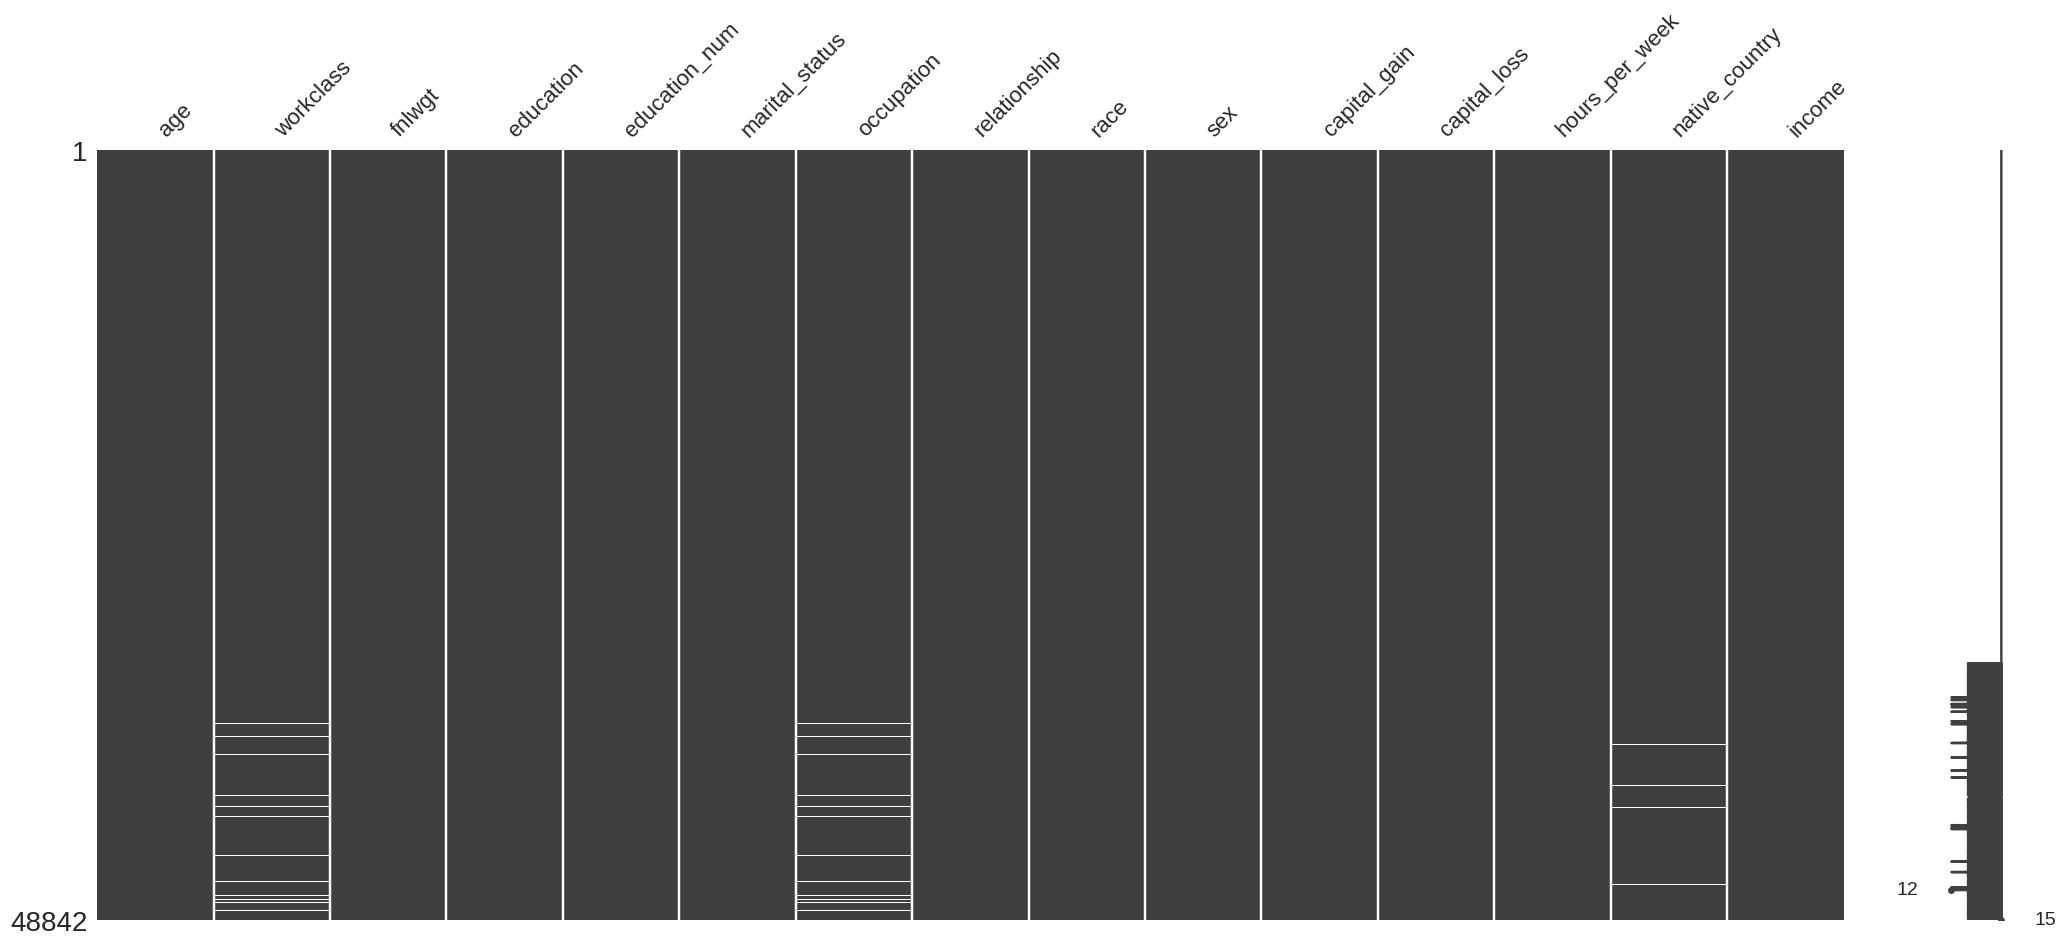

In [13]:
msno.matrix(data);

## EDA: Exploratory Data Analysis

In [ ]:
data["income"].value_counts(normalize=False)

income
<=50K     24720
<=50K.    12435
>50K       7841
>50K.      3846
Name: count, dtype: int64

### Target

In [ ]:
data = data.assign(income= lambda dfr: dfr.income.str.replace(".", ""))

In [14]:
label_distribution = data.groupby(['income']).size().reset_index(name='count')
label_distribution

income  count
0   <=50K  24720
1  <=50K.  12435
2    >50K   7841
3   >50K.   3846

In [15]:
# Plot a pie chart with custom colors for income
fig = px.pie(
    label_distribution,
    names='income',  # Use 'income' for pie segments
    values='count',  # Use 'count' for the size of each pie slice
    # color='income',  # Color the segments based on income
    title='Income distribution',
    labels={'income': 'Income', 'count': 'Count'},
)

fig.update_traces(textinfo='percent+label')  # Display percentage and labels on the pie chart

fig.show()

### Categorical features

In [16]:
categorical_columns = data.select_dtypes(include="object").columns

categorical_columns

Index(['workclass', 'education', 'marital_status', 'occupation',
       'relationship', 'race', 'sex', 'native_country', 'income'],
      dtype='object')

In [17]:
for col_name in categorical_columns:
    logger.info(f"{col_name} ==============\n {data[col_name].value_counts(dropna=False)}\n")

2025-04-24 14:26:05.105 | INFO     | __main__:<cell line: 0>:2 - workclass ==============
 workclass
Private             33906
Self-emp-not-inc     3862
Local-gov            3136
State-gov            1981
?                    1836
Self-emp-inc         1695
Federal-gov          1432
NaN                   963
Without-pay            21
Never-worked           10
Name: count, dtype: int64

2025-04-24 14:26:05.108 | INFO     | __main__:<cell line: 0>:2 - education ==============
 education
HS-grad         15784
Some-college    10878
Bachelors        8025
Masters          2657
Assoc-voc        2061
11th             1812
Assoc-acdm       1601
10th             1389
7th-8th           955
Prof-school       834
9th               756
12th              657
Doctorate         594
5th-6th           509
1st-4th           247
Preschool          83
Name: count, dtype: int64

2025-04-24 14:26:05.111 | INFO     | __main__:<cell line: 0>:2 - marital_status ==============
 marital_status
Married-civ-spouse   

#### Preprocessing

In [21]:
# Replace “?” with None for all columns containing it
data.replace("?", None, inplace=True)

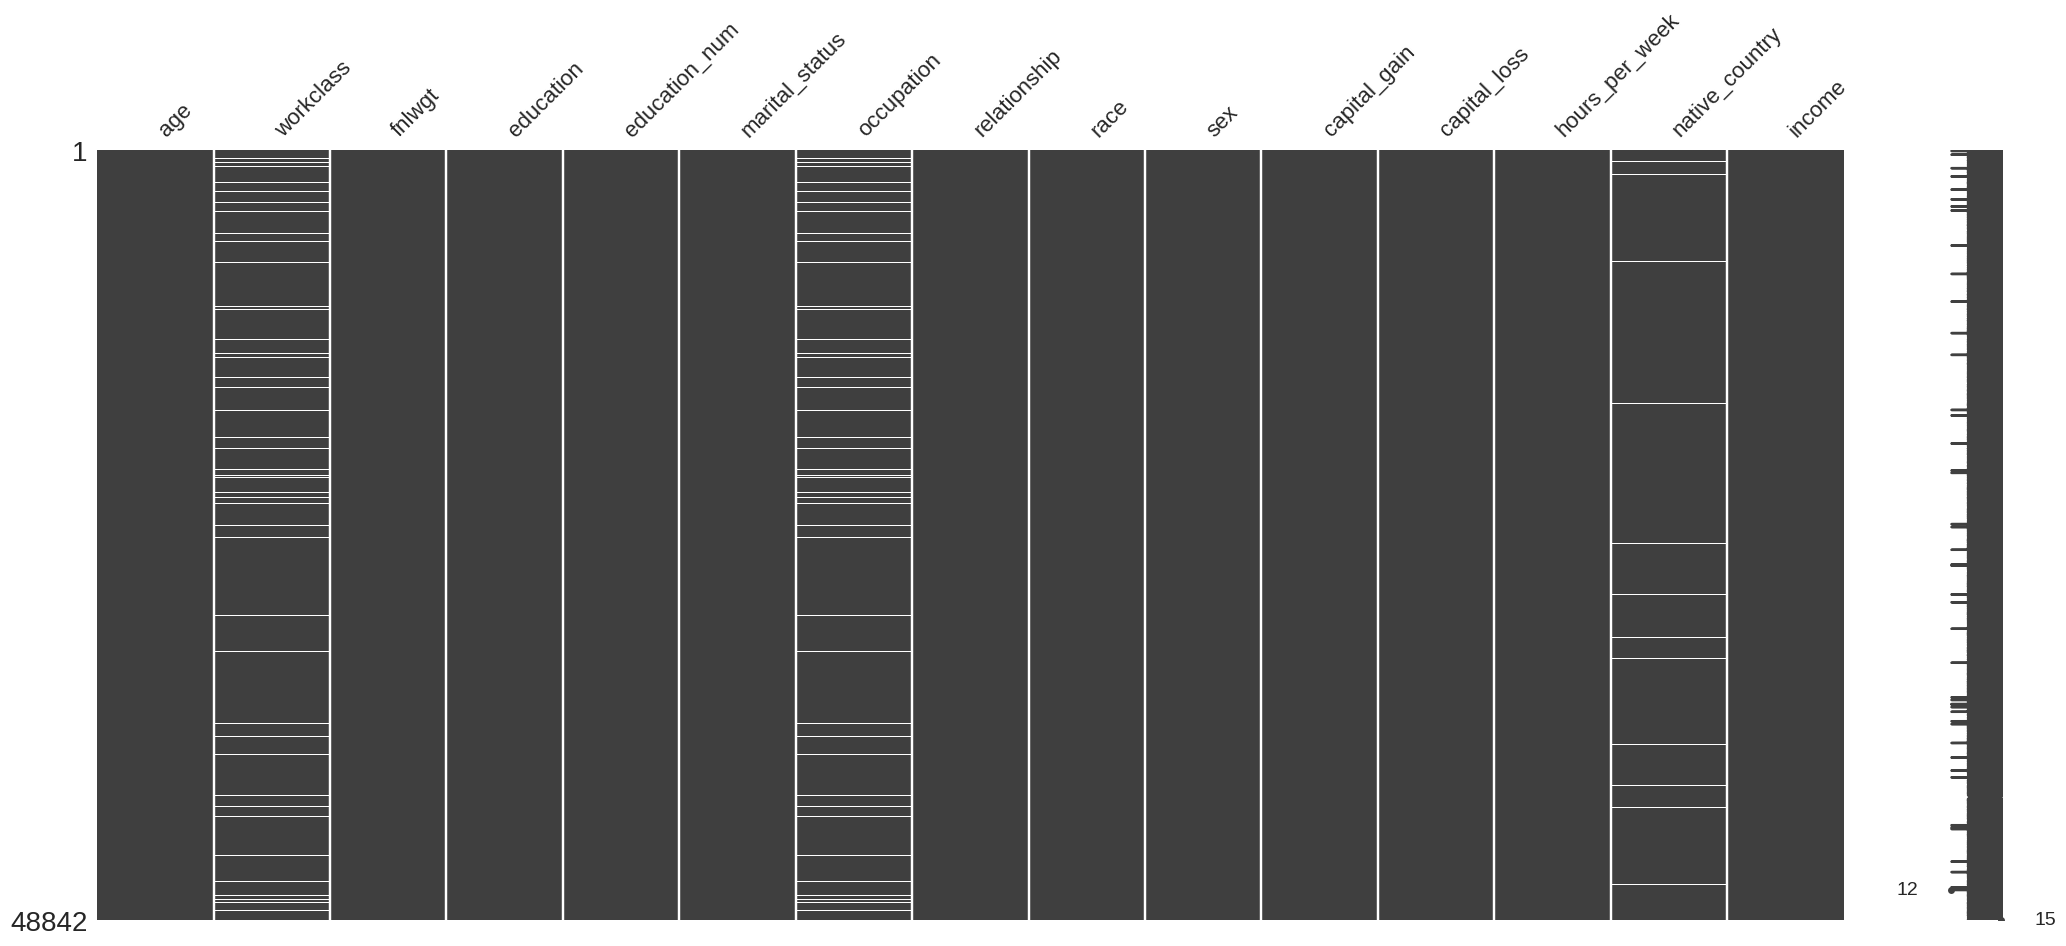

In [22]:
msno.matrix(data);

### Remove Duplicated

In [ ]:
# Shape after deduplication
data.shape

(48842, 15)

In [ ]:
# Check for the duplicates: if True then there are duplicated
data.duplicated().any()

True

In [23]:
data[data.duplicated(keep=False)].sort_values(["workclass", "education", "relationship"])

age         workclass  fnlwgt     education  education_num  \
5842    25           Private  195994       1st-4th              2   
13084   25           Private  195994       1st-4th              2   
22300   25           Private  195994       1st-4th              2   
21103   23           Private  240137       5th-6th              3   
25872   23           Private  240137       5th-6th              3   
7920    49           Private   31267       7th-8th              4   
21875   49           Private   31267       7th-8th              4   
39582   30           Private  180317     Assoc-voc             11   
46409   30           Private  180317     Assoc-voc             11   
33880   37           Private   52870     Bachelors             13   
43750   37           Private   52870     Bachelors             13   
4325    25           Private  308144     Bachelors             13   
4881    25           Private  308144     Bachelors             13   
17916   44           Private  367749     Bachelors             13   
22367   44           Private  367749     Bachelors             13   
33049   24           Private  194630     Bachelors             13   
33425   24           Private  194630     Bachelors             13   
41810   29           Private   36440     Bachelors             13   
43773   29           Private   36440     Bachelors             13   
4940    38           Private  207202       HS-grad              9   
16297   46           Private  173243       HS-grad              9   
17040   46           Private  173243       HS-grad              9   
25624   39           Private   30916       HS-grad              9   
28846   39           Private   30916       HS-grad              9   
29157   38           Private  207202       HS-grad              9   
5579    27           Private  255582       HS-grad              9   
16846   35           Private  379959       HS-grad              9   
16975   30           Private  144593       HS-grad              9   
17673   19           Private   97261       HS-grad              9   
18555   30           Private  144593       HS-grad              9   
18698   19           Private   97261       HS-grad              9   
28230   27           Private  255582       HS-grad              9   
32404   35           Private  379959       HS-grad              9   
8679    28           Private  274679       Masters             14   
26313   28           Private  274679       Masters             14   
8080    21           Private  243368     Preschool              1   
15059   21           Private  243368     Preschool              1   
10367   42           Private  204235  Some-college             10   
28522   42           Private  204235  Some-college             10   
2303    90           Private   52386  Some-college             10   
5104    90           Private   52386  Some-college             10   
5805    20           Private  107658  Some-college             10   
11631   20           Private  107658  Some-college             10   
3917    19           Private  251579  Some-college             10   
4767    21           Private  250051  Some-college             10   
6990    19           Private  138153  Some-college             10   
9171    21           Private  250051  Some-college             10   
15189   19           Private  146679  Some-college             10   
21318   19           Private  138153  Some-college             10   
21490   19           Private  146679  Some-college             10   
31993   19           Private  251579  Some-college             10   
11965   46           Private  133616  Some-college             10   
30845   46           Private  133616  Some-college             10   
36461   18      Self-emp-inc  378036          12th              8   
48521   18      Self-emp-inc  378036          12th              8   
7053    49  Self-emp-not-inc   43479  Some-college             10   
22494   49  Self-emp-not-inc   43479  Some-college             10   

    

In [32]:
# Drop duplicates
data = data.drop_duplicates(keep='first', inplace=False)
data.shape

(48813, 16)

In [33]:
# Shape after deduplication
data.shape

(48813, 16)

### Numerical features

In [34]:
data["capital_diff"] = data['capital_gain'] - data['capital_loss']

In [30]:
numeric_columns = data.select_dtypes(include=['float64', 'int64']).columns

In [35]:
# Initialize a figure
fig = go.Figure()

# Iterate over numeric columns in the DataFrame
for column in numeric_columns:
    fig.add_trace(go.Box(
        y=data[column],
        name=column,
        marker=dict(color='skyblue')
    ))

# Update layout with a title and axis labels
fig.update_layout(
    title='Distribution of Numeric Columns without Outliers',
    yaxis_title='Values',
    xaxis_title='Numeric Columns'
)

# Show the figure
fig.show()


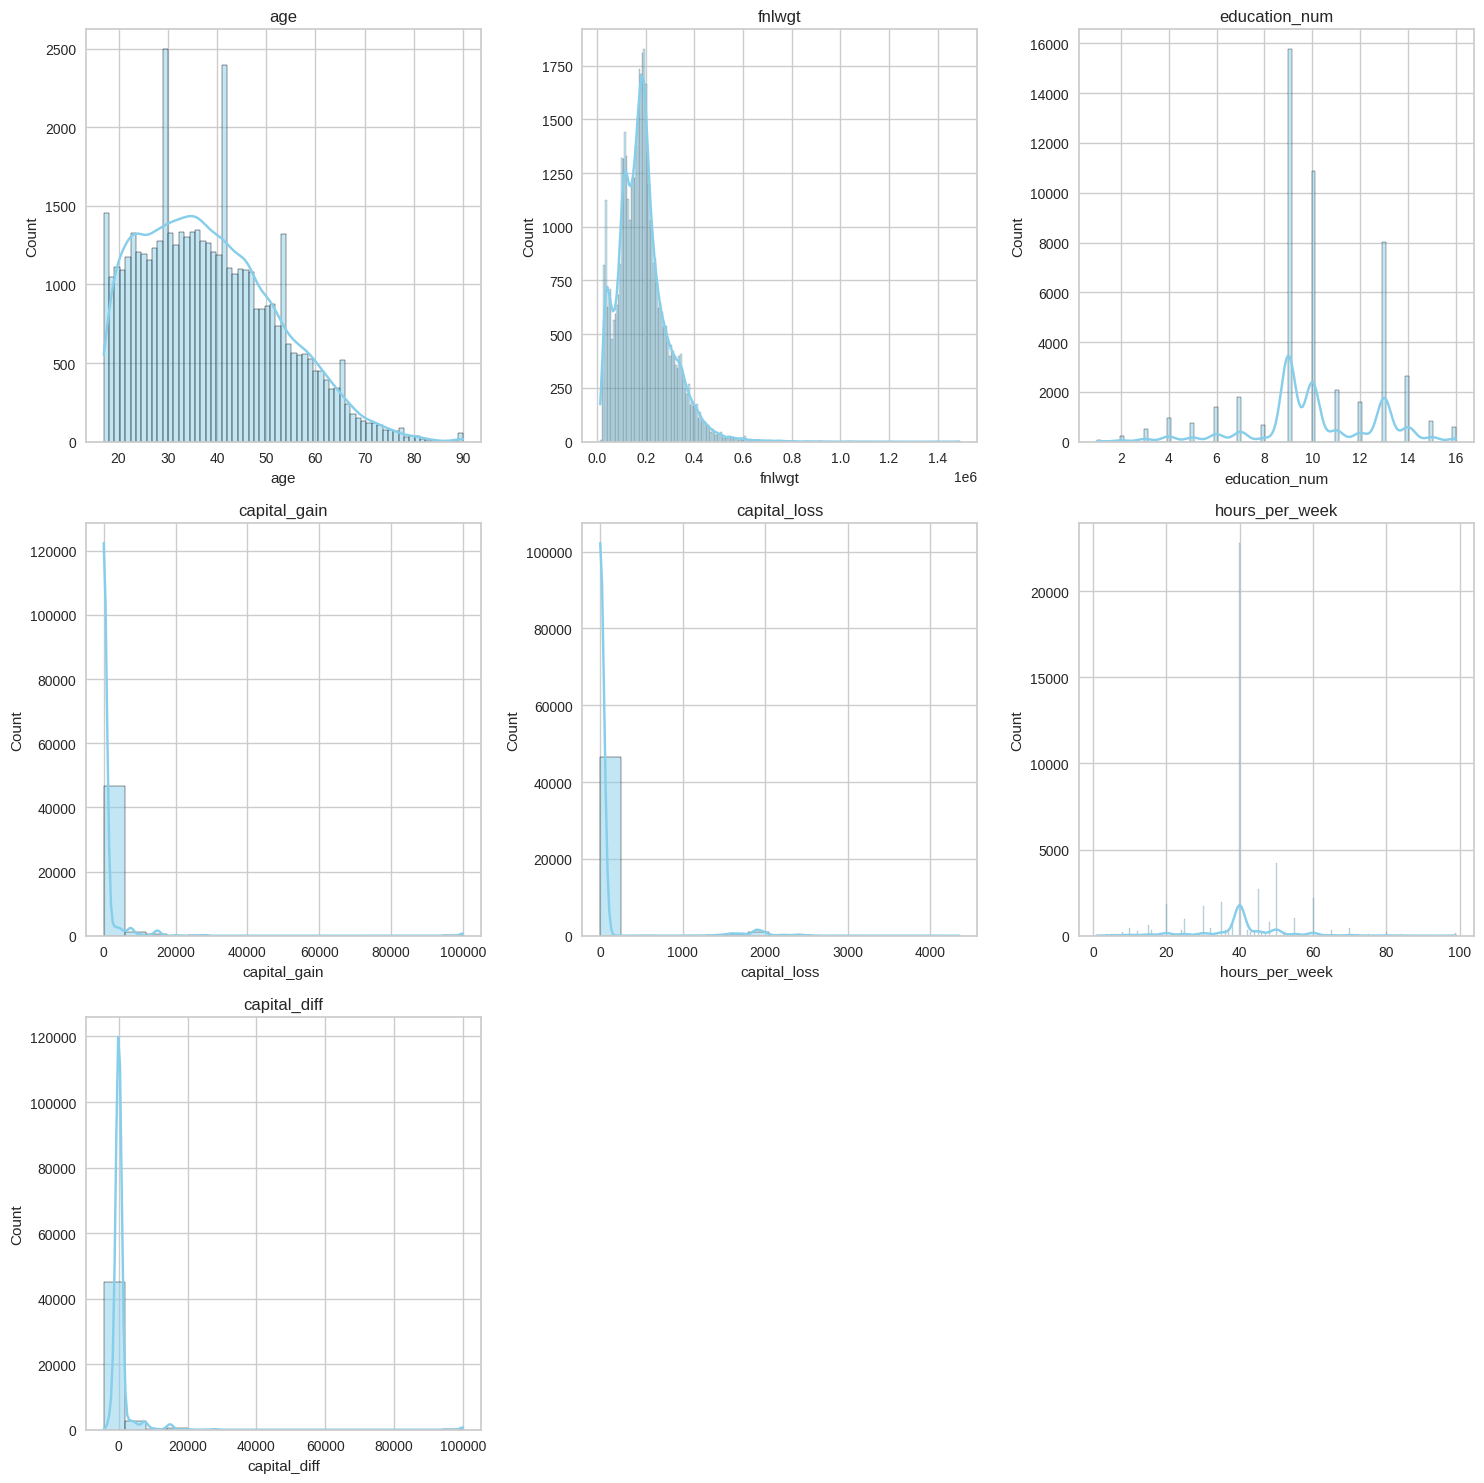

In [36]:
n_cols = 3
n_rows = (len(numeric_columns) + n_cols - 1) // n_cols

fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 5 * n_rows))
axes = axes.flatten()

for i, col_name in enumerate(numeric_columns):
    sns.histplot(data[col_name], kde=True, ax=axes[i], color='skyblue')
    axes[i].set_title(col_name)

for i in range(len(numeric_columns), len(axes)):
    fig.delaxes(axes[i])

plt.tight_layout()
plt.show()

### Bivariate analysis

In [37]:
px.box(
    data,
    x='income',  # Income category on the x-axis
    y='age',  # Age distribution on the y-axis
    title='Age Distribution by Income',
    labels={'income': 'Income Category', 'age': 'Age'}
)

In [38]:
data

age         workclass  fnlwgt  education  education_num  \
0       39         State-gov   77516  Bachelors             13   
1       50  Self-emp-not-inc   83311  Bachelors             13   
2       38           Private  215646    HS-grad              9   
3       53           Private  234721       11th              7   
4       28           Private  338409  Bachelors             13   
...    ...               ...     ...        ...            ...   
48837   39           Private  215419  Bachelors             13   
48838   64               NaN  321403    HS-grad              9   
48839   38           Private  374983  Bachelors             13   
48840   44           Private   83891  Bachelors             13   
48841   35      Self-emp-inc  182148  Bachelors             13   

           marital_status         occupation    relationship  \
0           Never-married       Adm-clerical   Not-in-family   
1      Married-civ-spouse    Exec-managerial         Husband   
2                Divorced  Handlers-cleaners   Not-in-family   
3      Married-civ-spouse  Handlers-cleaners         Husband   
4      Married-civ-spouse     Prof-specialty            Wife   
...                   ...                ...             ...   
48837            Divorced     Prof-specialty   Not-in-family   
48838             Widowed                NaN  Other-relative   
48839  Married-civ-spouse     Prof-specialty         Husband   
48840            Divorced       Adm-clerical       Own-child   
48841  Married-civ-spouse    Exec-managerial         Husband   

                     race     sex  capital_gain  capital_loss  hours_per_week  \
0                   White    Male          2174             0              40   
1                   White    Male             0             0              13   
2                   White    Male             0             0              40   
3                   Black    Male             0             0              40   
4                   Black  Female             0             0              40   
...                   ...     ...           ...           ...             ...   
48837               White  Female             0             0              36   
48838               Black    Male             0             0              40   
48839               White    Male             0             0              50   
48840  Asian-Pac-Islander    Male          5455             0              40   
48841               White    Male             0             0              60   

      native_country  income  capital_diff  
0      United-States   <=50K          2174  
1      United-States   <=50K             0  
2      United-States   <=50K             0  
3      United-States   <=50K             0  
4               Cuba   <=50K             0  
...              ...     ...           ...  
48837  United-States  <=50K.             0  
48838  United-States  <=50K.             0  
48839  United-States  <=50K.             0  
48840  United-States  <=50K.          5455  
48841  United-States   >50K.             0  

[48813 rows x 16 columns]

In [39]:
for col_name in ["workclass",
                 "education",
                 "marital_status",
                 "sex"
                ]:

    feature_income_counts = data.groupby([col_name, 'income']).size().unstack()

    fig = px.bar(feature_income_counts,
                 barmode='stack',  # Stack bars for income categories
                 title=f'Relationship between Income and {col_name}',
                 labels={'value': 'Count'}
                )
    fig.show()

In [40]:
for col_name in numeric_columns:

    #counts
    num_feat_income_counts = data.groupby([col_name, "income"]).size().unstack()

    # Plot using iplot
    fig = px.area(num_feat_income_counts,
                  title=f"Relationship between {col_name} and income",
                  labels={"value": "Count"}
                 )
    fig.show()

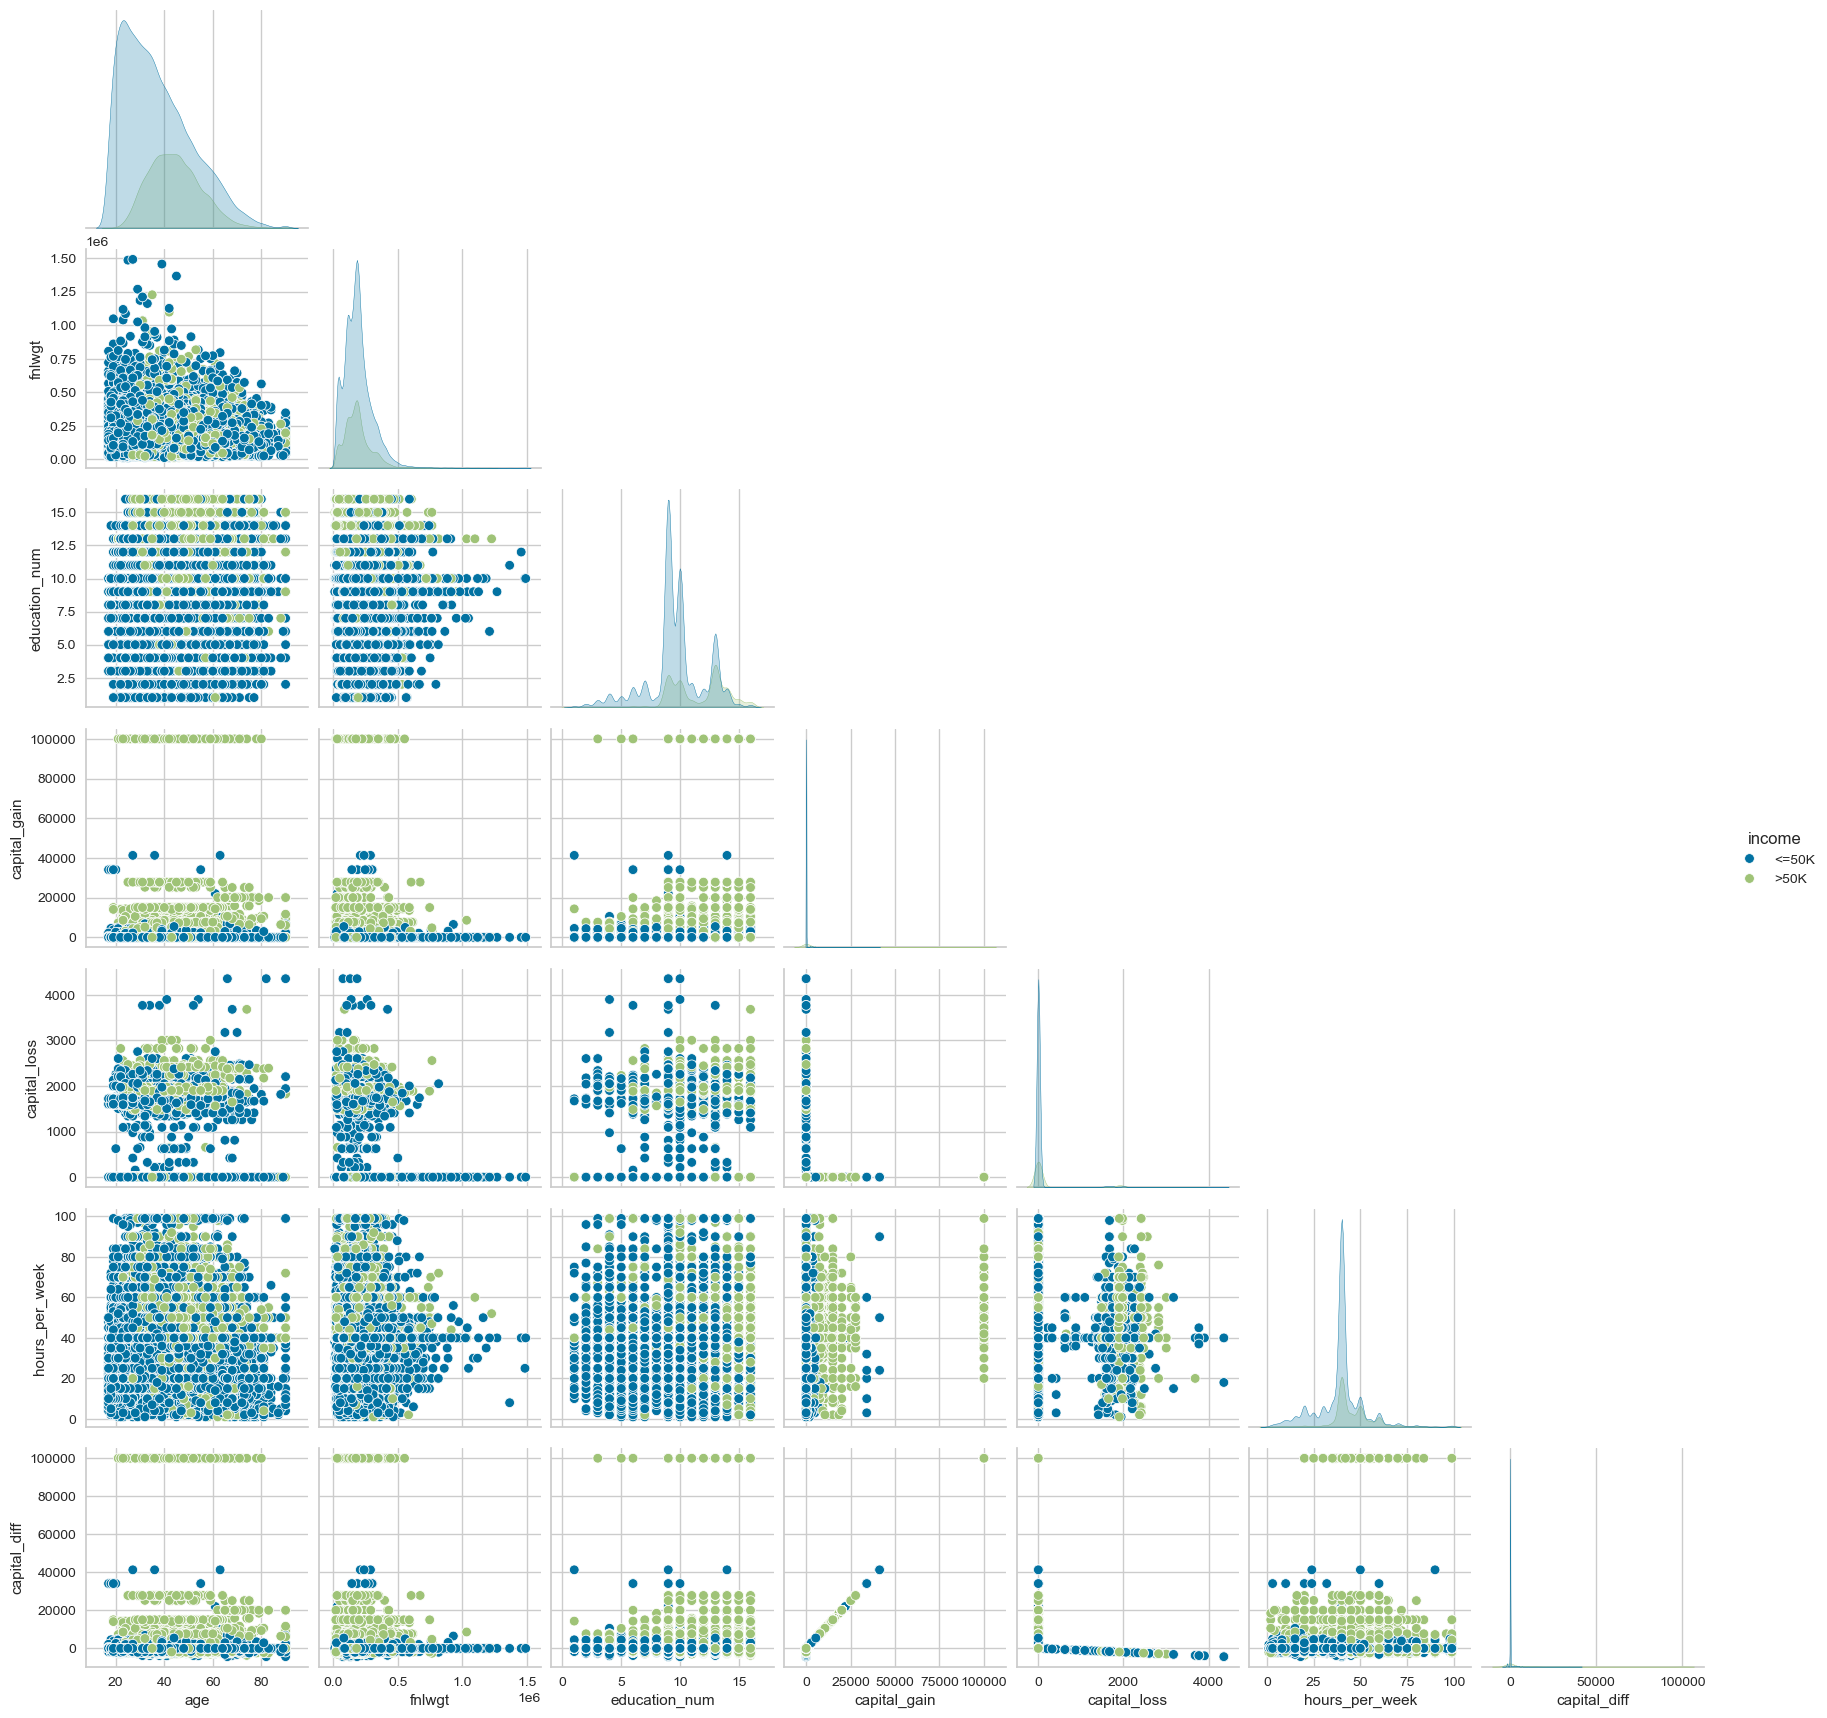

In [ ]:
sns.pairplot(data, hue="income", corner=True);

### Correlation

In [ ]:
corr_matrix = data.loc[:, numeric_columns].corr()


In [ ]:
data.loc[:, numeric_columns].corr()

age    fnlwgt  education_num  capital_gain  capital_loss  \
age             1.000000 -0.076451       0.030635      0.077185      0.056838   
fnlwgt         -0.076451  1.000000      -0.038727     -0.003715     -0.004378   
education_num   0.030635 -0.038727       1.000000      0.125219      0.080986   
capital_gain    0.077185 -0.003715       0.125219      1.000000     -0.031475   
capital_loss    0.056838 -0.004378       0.080986     -0.031475      1.000000   
hours_per_week  0.071223 -0.013521       0.143915      0.082152      0.054431   
capital_diff    0.073878 -0.003467       0.120459      0.998547     -0.085285   

                hours_per_week  capital_diff  
age                   0.071223      0.073878  
fnlwgt               -0.013521     -0.003467  
education_num         0.143915      0.120459  
capital_gain          0.082152      0.998547  
capital_loss          0.054431     -0.085285  
hours_per_week        1.000000      0.078959  
capital_diff          0.078959      1.000000

<Axes: >

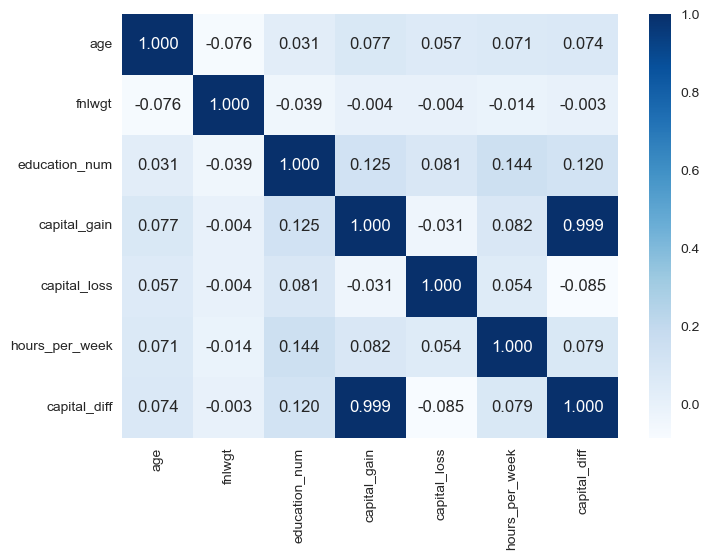

In [ ]:
sns.heatmap(corr_matrix, annot=True, fmt=".3f", cmap="Blues")

## Data preparation

In [ ]:
data.head()

age         workclass  fnlwgt  education  education_num  \
0   39         State-gov   77516  Bachelors             13   
1   50  Self-emp-not-inc   83311  Bachelors             13   
2   38           Private  215646    HS-grad              9   
3   53           Private  234721       11th              7   
4   28           Private  338409  Bachelors             13   

       marital_status         occupation   relationship   race     sex  \
0       Never-married       Adm-clerical  Not-in-family  White    Male   
1  Married-civ-spouse    Exec-managerial        Husband  White    Male   
2            Divorced  Handlers-cleaners  Not-in-family  White    Male   
3  Married-civ-spouse  Handlers-cleaners        Husband  Black    Male   
4  Married-civ-spouse     Prof-specialty           Wife  Black  Female   

   capital_gain  capital_loss  hours_per_week native_country income  \
0          2174             0              40  United-States  <=50K   
1             0             0              13  United-States  <=50K   
2             0             0              40  United-States  <=50K   
3             0             0              40  United-States  <=50K   
4             0             0              40           Cuba  <=50K   

   capital_diff  
0          2174  
1             0  
2             0  
3             0  
4             0

In [ ]:
# Removing rows where 'Workclass' is 'Without-pay' and 'Never-worked'
data = data[~data["workclass"].str.lower().isin(["without-pay", "never-worked"])
            # & data["hours_per_week"].between(20, 60)
           ]
data.shape

(48759, 16)

In [ ]:
data["hours_per_week"].value_counts(sort=False).sort_index()

hours_per_week
1      27
2      53
3      59
4      83
5      95
     ... 
95      2
96      9
97      2
98     14
99    137
Name: count, Length: 96, dtype: int64

In [ ]:
#Feature mapping
workclass_mapping = {
    'Private': 'Private',
    'Self-emp-not-inc': 'Self-Employed',
    'Local-gov': 'Government',
    'State-gov': 'Government',
    'Self-emp-inc': 'Self-Employed',
    'Federal-gov': 'Government',
    'Without-pay': 'Other',
    'Never-worked': 'Other'
}

marital_status_mapping = {
    "Married-civ-spouse": "Married",
    "Married-spouse-absent": "Married",
    "Married-AF-spouse": "Married",
    "Separated": "Married",
    "Never-married": "Single",
    "Divorced": "Single",
    "Widowed": "Single"
}

relationship_mapping = {
    'Husband': 'spouse',
    'Not-in-family': 'Others:',
    'Own-child': 'Immediate Family',
    'Unmarried': 'Others:',
    'Wife': 'spouse',
    'Other-relative': 'Immediate Family',
}

# occupation
# occupation_mapping = to be defined if necessary

In [ ]:
data = data.assign(income=lambda dfr: dfr['income'].map({"<=50K": 0, ">50K": 1}),
                   # capital_diff_bin = lambda dfr: pd.cut(dfr['capital_diff'], bins = [-5000, 5000, 100000], labels = ['Low', 'High'])
                   native_country=lambda dfr: dfr["native_country"].fillna("United-States").map(lambda val: val if val == "United-States" else "Others"),
                   education=lambda dfr: dfr.education.replace(["11th", "9th", "7th-8th", "5th-6th", "10th", "1st-4th", "12th"], "School"),
                   race=lambda dfr: dfr.race.map(lambda val: 'White' if val == 'White' else 'Others'),
                   # workclass=lambda dfr: dfr.workclass.map(workclass_mapping),
                   # marital_status=lambda dfr: dfr.marital_status.map(marital_status_mapping),
                   # relationship=lambda dfr: dfr.relationship.map(relationship_mapping),
                  )

## Train / test split

In [ ]:
data.drop(['capital_gain',
           'capital_loss',
           "fnlwgt",  # fnlwgt (Final Weight): Represents the weight assigned to each individual.
           "education_num",
       ], axis=1, inplace=True)


In [ ]:
x_values = data.drop(columns=['income'])
y_target = data.income

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(x_values, y_target, test_size=0.2, random_state=42, stratify=y_target)

In [ ]:
x_train.head()

age         workclass     education      marital_status  \
44101   35         Local-gov     Bachelors  Married-civ-spouse   
36845   61           Private       HS-grad            Divorced   
44706   41           Private  Some-college            Divorced   
35127   49  Self-emp-not-inc        School  Married-civ-spouse   
41678   37  Self-emp-not-inc     Assoc-voc  Married-civ-spouse   

              occupation   relationship   race     sex  hours_per_week  \
44101    Protective-serv        Husband  White    Male              48   
36845  Machine-op-inspct  Not-in-family  White  Female              40   
44706              Sales      Unmarried  White    Male              46   
35127    Farming-fishing        Husband  White    Male              50   
41678    Farming-fishing        Husband  White    Male              60   

      native_country  capital_diff  
44101  United-States             0  
36845  United-States             0  
44706  United-States             0  
35127  United-States             0  
41678  United-States             0

In [ ]:
y_train.value_counts(normalize=True).mul(100).round(2)

income
0    76.05
1    23.95
Name: proportion, dtype: float64

In [ ]:
y_train.value_counts(normalize=True).mul(100).round(2)

income
0    76.05
1    23.95
Name: proportion, dtype: float64

### Feature engineering

In [ ]:
x_values.head()

age         workclass  education      marital_status         occupation  \
0   39         State-gov  Bachelors       Never-married       Adm-clerical   
1   50  Self-emp-not-inc  Bachelors  Married-civ-spouse    Exec-managerial   
2   38           Private    HS-grad            Divorced  Handlers-cleaners   
3   53           Private     School  Married-civ-spouse  Handlers-cleaners   
4   28           Private  Bachelors  Married-civ-spouse     Prof-specialty   

    relationship    race     sex  hours_per_week native_country  capital_diff  
0  Not-in-family   White    Male              40  United-States          2174  
1        Husband   White    Male              13  United-States             0  
2  Not-in-family   White    Male              40  United-States             0  
3        Husband  Others    Male              40  United-States             0  
4           Wife  Others  Female              40         Others             0

In [ ]:
# numerical
numeric_features = x_values.select_dtypes(include="number").columns

# categorical
onehot_features = ['workclass', 'occupation', 'relationship', 'race', 'sex', 'marital_status']

country_feature = ["native_country"]
ordinal_features = ['education',
                   # 'capital_diff_bin',
                  ]

cat_for_edu = ['Preschool', 'School', 'HS-grad','Some-college', 'Assoc-voc', 'Assoc-acdm','Bachelors', 'Masters', 'Prof-school', 'Doctorate']
cat_for_capdiff = ['Low', 'High']

In [ ]:
x_train.loc[:, numeric_features]

age  hours_per_week  capital_diff
44101   35              48             0
36845   61              40             0
44706   41              46             0
35127   49              50             0
41678   37              60             0
...    ...             ...           ...
2324    63              50             0
30520   21              40             0
42196   60              25             0
41858   34              40             0
26127   19              35             0

[39007 rows x 3 columns]

In [ ]:
x_train.loc[:, numeric_features]

age  hours_per_week  capital_diff
44101   35              48             0
36845   61              40             0
44706   41              46             0
35127   49              50             0
41678   37              60             0
...    ...             ...           ...
2324    63              50             0
30520   21              40             0
42196   60              25             0
41858   34              40             0
26127   19              35             0

[39007 rows x 3 columns]

In [ ]:
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])


# Education : ordinal + imputation 'undefined' gérée via catégorie manquante
ordinal_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='undefined')),
    ('ordinal', OrdinalEncoder(categories=[cat_for_edu + ['undefined']], handle_unknown='use_encoded_value', unknown_value=-1))
])

# OneHot : autres variables catégorielles avec imputation "undefined"
onehot_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='undefined')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# Native country : imputation avec "United-States"
country_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='United-States')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# Pipeline
preprocessor = ColumnTransformer(transformers=[
    ('num', numeric_transformer, numeric_features),
    ('ord', ordinal_transformer, ordinal_features),
    ('cat', onehot_transformer, onehot_features),
    ('country', country_transformer, country_feature)
])



preprocessor

ColumnTransformer(transformers=[('num',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(strategy='median')),
                                                 ('scaler', StandardScaler())]),
                                 Index(['age', 'hours_per_week', 'capital_diff'], dtype='object')),
                                ('ord',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(fill_value='undefined',
                                                                strategy='constant')),
                                                 ('ordinal',
                                                  OrdinalEncoder(categories=[['Preschool',
                                                                              'School',
                                                                              'HS-...
                                                  SimpleImputer(fill_value='undefined',
                                                                strategy='constant')),
                                                 ('onehot',
                                                  OneHotEncoder(handle_unknown='ignore'))]),
                                 ['workclass', 'occupation', 'relationship',
                                  'race', 'sex', 'marital_status']),
                                ('country',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(fill_value='United-States',
                                                                strategy='constant')),
                                                 ('onehot',
                                                  OneHotEncoder(handle_unknown='ignore'))]),
                                 ['native_country'])])

## Modeling

#### Dummy regressor

In [ ]:
# Pipeline
dm_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('clf', DummyClassifier())
])

dm_pipeline

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  Index(['age', 'hours_per_week', 'capital_diff'], dtype='object')),
                                                 ('ord',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(fill_value='undefined',
                                                                                 strategy='constant')),
                                                                  ('ordinal',
                                                                   OrdinalEncoder(catego...
                                                                                 strategy='constant')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['workclass', 'occupation',
                                                   'relationship', 'race',
                                                   'sex', 'marital_status']),
                                                 ('country',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(fill_value='United-States',
                                                                                 strategy='constant')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['native_country'])])),
                ('clf', DummyClassifier())])

In [ ]:
# Training
dm_pipeline.fit(x_train, y_train)

# Predictions & evaluation
dm_y_pred_test = dm_pipeline.predict(x_test)
dm_y_proba_test = dm_pipeline.predict_proba(x_test)[:, 1]


logger.info(f"AUC: {roc_auc_score(y_test, dm_y_proba_test):.2f}")

logger.info(f"Classification report: \n{classification_report(y_test, dm_y_pred_test)}")

2025-04-17 07:46:42.366 | INFO     | __main__:<module>:9 - AUC: 0.50
/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

2025-04-17 07:46:42.374 | INFO     | __main__:<module>:11 - Classification report: 
              precision    recall  f1-score   support

           0       0.76      1.00      0.8

#### Logistic regression

In [ ]:
# Pipeline
rl_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('clf', LogisticRegression(max_iter=1000))
])

rl_pipeline

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  Index(['age', 'hours_per_week', 'capital_diff'], dtype='object')),
                                                 ('ord',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(fill_value='undefined',
                                                                                 strategy='constant')),
                                                                  ('ordinal',
                                                                   OrdinalEncoder(catego...
                                                                                 strategy='constant')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['workclass', 'occupation',
                                                   'relationship', 'race',
                                                   'sex', 'marital_status']),
                                                 ('country',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(fill_value='United-States',
                                                                                 strategy='constant')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['native_country'])])),
                ('clf', LogisticRegression(max_iter=1000))])

##### Baseline

In [ ]:
# 8. Entraînement
rl_pipeline.fit(x_train, y_train)

# 9. Prédictions & évaluation
rl_y_pred_test = rl_pipeline.predict(x_test)
rl_y_proba_test = rl_pipeline.predict_proba(x_test)[:, 1]


logger.info(f"AUC: {roc_auc_score(y_test, rl_y_proba_test):.2f} ")

logger.info(f"Classification report: \n{classification_report(y_test, rl_y_pred_test)}")

2025-04-17 07:46:44.750 | INFO     | __main__:<module>:9 - AUC: 0.90 
2025-04-17 07:46:44.756 | INFO     | __main__:<module>:11 - Classification report: 
              precision    recall  f1-score   support

           0       0.88      0.93      0.90      7416
           1       0.72      0.59      0.65      2336

    accuracy                           0.85      9752
   macro avg       0.80      0.76      0.78      9752
weighted avg       0.84      0.85      0.84      9752



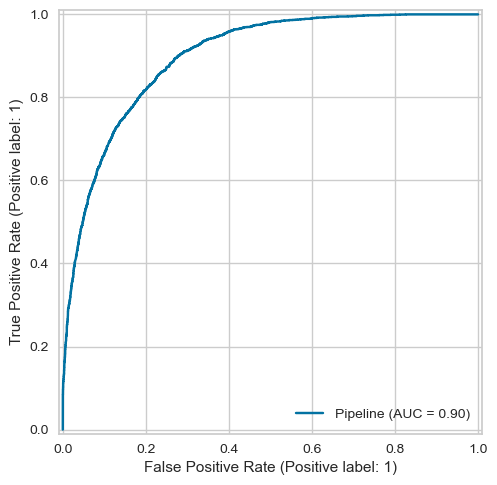

In [ ]:
RocCurveDisplay.from_estimator(rl_pipeline, x_test, y_test);

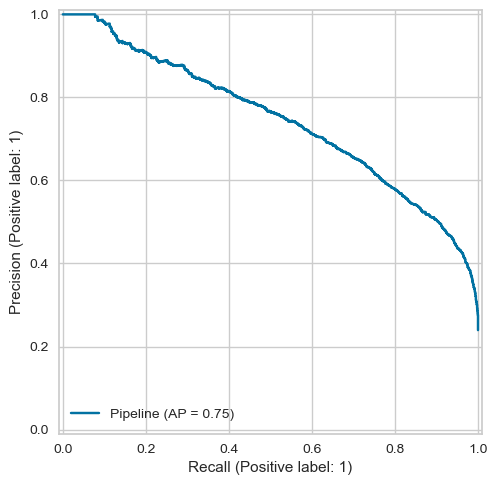

In [ ]:
PrecisionRecallDisplay.from_estimator(rl_pipeline, x_test, y_test);


##### Tuning hyperparameters

In [ ]:
rl_param_grid = {
    "clf__penalty": ["l2"],  # 'l1' si solver = 'liblinear' ou 'saga'
    "clf__C": [0.01, 0.1, 1, 2, 3, 5, 10],
    "clf__solver": ['liblinear', 'lbfgs', "sag", "saga"],  # lbfgs ne supporte que l2
    "clf__class_weight": ['balanced', None],
}

In [ ]:
# Cross-validation
cv = StratifiedKFold(n_splits=5)

rl_grid_search = GridSearchCV(rl_pipeline, rl_param_grid, cv=cv, scoring='roc_auc', n_jobs=-1)

# Training
rl_grid_search.fit(x_train, y_train)

# Best params
logger.info(f"Best params : {rl_grid_search.best_params_}")

# Evaluation
rl_y_pred_test_opt = rl_grid_search.predict(x_test)
rl_y_proba_test_opt  = rl_grid_search.predict_proba(x_test)[:, 1]

logger.info(f"AUC : {roc_auc_score(y_test, rl_y_proba_test_opt):.2f}")
logger.info(f"F1-score : {f1_score(y_test, rl_y_pred_test_opt):.2f}")
logger.info(f"Accuracy : {accuracy_score(y_test, rl_y_pred_test_opt):.2f}")


/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max

##### Discrimination threshold

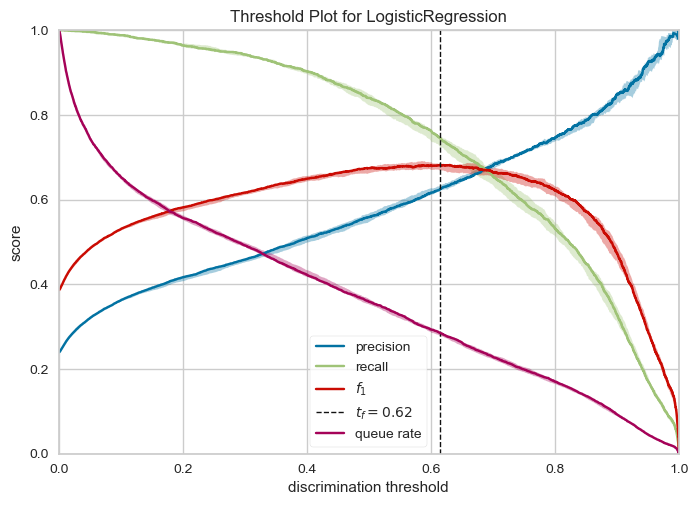

In [ ]:
viz = DiscriminationThreshold(rl_grid_search.best_estimator_, random_state=42, fbeta=1.0, cv=cv, argmax="fscore")

# Fit et plot
viz.fit(x_train, y_train)
viz.score(x_test, y_test)
viz.show();

##### Model analysis

In [ ]:
# features importances

##### Save model

In [ ]:
# Save model

model_path_name = Path(MODEL_DIR, "best_logistic_model.dill")

logger.info(f"Model path name: {model_path_name}")
with open(model_path_name, "wb") as fp:
    dill.dump(rl_grid_search.best_estimator_, fp)

2025-04-17 07:53:32.613 | INFO     | __main__:<module>:5 - Model path name: /Users/mouslydiaw/Documents/ml-courses/classification/models/best_logistic_model.dill


### KNN

#### Baseline

In [ ]:
# Pipeline
knn_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('clf', KNeighborsClassifier(n_neighbors=10))
])

knn_pipeline

In [ ]:
# 8. Entraînement
knn_pipeline.fit(x_train, y_train)

# 9. Prédictions & évaluation
knn_y_pred_test = knn_pipeline.predict(x_test)
knn_y_proba_test = knn_pipeline.predict_proba(x_test)[:, 1]


logger.info(f"AUC: {roc_auc_score(y_test, knn_y_proba_test):.2f}")

logger.info(f"Classification report: \n{classification_report(y_test, knn_y_pred_test)}")

In [ ]:
ConfusionMatrixDisplay.from_estimator(knn_pipeline, x_test, y_test,
                                      display_labels=class_names,
                                      normalize="true", cmap=plt.cm.Blues);

In [ ]:
RocCurveDisplay.from_estimator(knn_pipeline, x_test, y_test);